Advanced ML: Домашнее задание 1

Это задание связано с анализом конкретного датасета, в котором, надеюсь, понадобится то, чему мы с вами до сих пор научились. В качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Любые комментарии, новые идеи и рассуждения на тему в этом ноутбуке категорически приветствуются. Датасет давайте возьмём довольно релевантный реальной жизни; он доступен по следующей ссылке:
https://ourworldindata.org/coronavirus-source-data

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
import seaborn as sns
from sklearn.linear_model import LinearRegression

sns.set_palette("colorblind")
palette = sns.color_palette()

1. Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).

In [2]:
#df_url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
#covid_df = pd.read_csv(df_url)

covid_df = pd.read_csv('owid-covid-data.csv')
covid_df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [3]:
covid_df[['iso_code', 'date', 'new_cases']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164710 entries, 0 to 164709
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   iso_code   164710 non-null  object 
 1   date       164710 non-null  object 
 2   new_cases  161640 non-null  float64
dtypes: float64(1), object(2)
memory usage: 3.8+ MB


In [4]:
covid_df['date'] = pd.to_datetime(covid_df['date'])

In [5]:
df = covid_df[['date', 'new_cases']][
    (covid_df['iso_code'] == 'RUS') & 
    (covid_df['date'] >= '2020-03-03')]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 726 entries, 122590 to 123315
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       726 non-null    datetime64[ns]
 1   new_cases  726 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 17.0 KB


In [6]:
df['new_cases'] = df['new_cases'].map(lambda x: 1 if x == 0 else x)
df.sort_values('date', inplace=True, ignore_index=True)
df['total_cases'] = df['new_cases'].cumsum()

df['log_new_cases'] = np.log(df['new_cases'])
df['ones'] = 1
df['day'] = df.index + 1
df['day_2'] = df['day'] ** 2

In [7]:
train = df.loc[:49]
test = df.loc[50:].reset_index(drop=True)

last_total_cases = train["total_cases"].tail(1).values

2. Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.

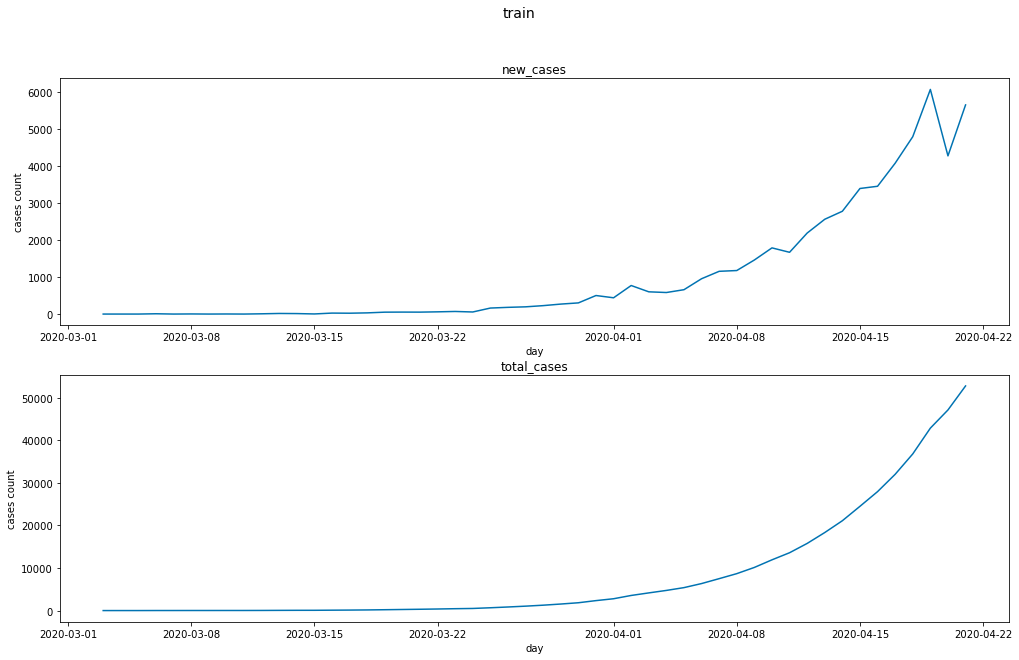

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(17, 10))

fig.suptitle('train', fontsize=14)

ax1.plot(train['date'], train['new_cases'])
ax1.set_title('new_cases')
ax1.set_xlabel('day')
ax1.set_ylabel('cases count')

ax2.plot(train['date'], train['total_cases'])
ax2.set_title('total_cases')
ax2.set_xlabel('day')
ax2.set_ylabel('cases count');

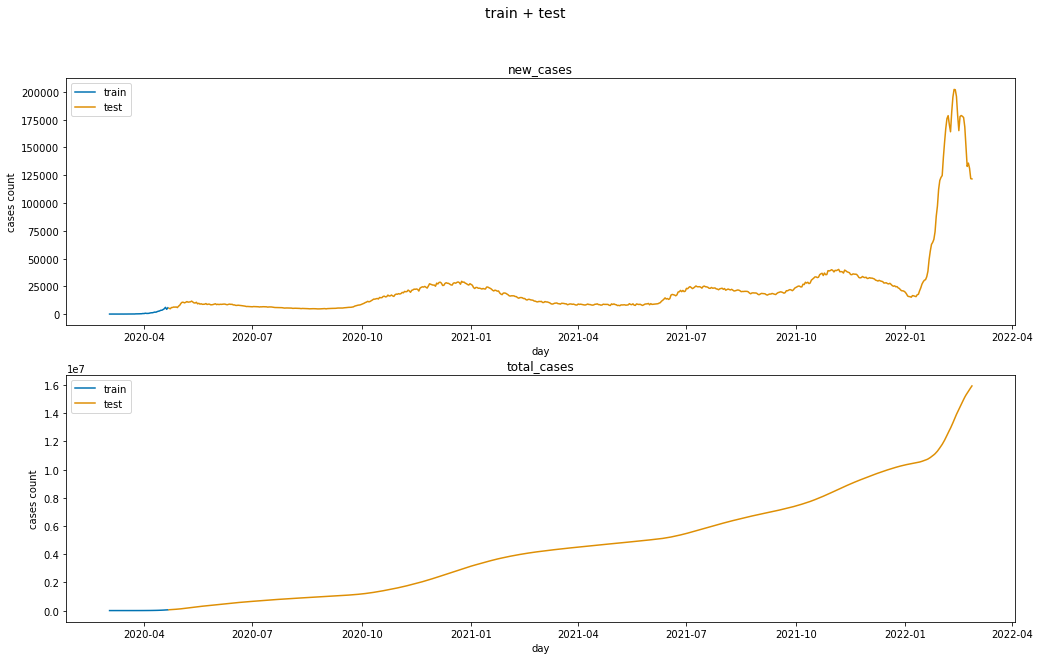

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(17, 10))

fig.suptitle('train + test', fontsize=14)

ax1.plot(train['date'], train['new_cases'], label='train')
ax1.plot(test['date'], test['new_cases'], label='test')
ax1.legend()
ax1.set_title('new_cases')
ax1.set_xlabel('day')
ax1.set_ylabel('cases count')

ax2.plot(train['date'], train['total_cases'], label='train')
ax2.plot(test['date'], test['total_cases'], label='test')
ax2.legend()
ax2.set_title('total_cases')
ax2.set_xlabel('day')
ax2.set_ylabel('cases count');

2.a. Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.

$$ y = c*{exp}^{a + bx} $$
$$ ln(y) = ln(c) + a + bx = A + bx $$

In [10]:
X_train = train[['ones', 'day']].values
y_train = train['log_new_cases'].values

X_test = test[['ones', 'day']].values

In [11]:
lr = LinearRegression(fit_intercept=False)
lr.fit(X_train, y_train)

print(f'ln(y) = {lr.coef_[0]} + ({lr.coef_[1]} * day)')

ln(y) = 0.13472442721454023 + (0.1859630916851052 * day)


In [12]:
def new_cases_predict(X, w):
    pred = X.dot(w)
    return np.exp(pred)

In [13]:
def total_cases_predict(pred, last_total_cases):
    return np.cumsum(pred) + last_total_cases

In [14]:
y_pred = new_cases_predict(X_test, lr.coef_)
y_cum_pred = total_cases_predict(y_pred, last_total_cases)

In [15]:
def plot_lr_prediction(ylim1=None, ylim2=None):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 15))
    
    fig.suptitle('train + test', fontsize=14)
    
    ax1.plot(train['date'], train['new_cases'], label='train')
    ax1.plot(test['date'], test['new_cases'], label='test')
    ax1.plot(test['date'], y_pred, label='prediction')
    
    ax1.legend()
    ax1.set_title('new_cases')
    ax1.set_xlabel('day')
    ax1.set_ylabel('cases count')
    if ylim1 is not None:
        ax1.set_ylim((0, ylim1))
    
    ax2.plot(train['date'], train['total_cases'], label='train')
    ax2.plot(test['date'], test['total_cases'], label='test')
    ax2.plot(test['date'], y_cum_pred, label='prediction')
    
    ax2.legend()
    ax2.set_title('total_cases')
    ax2.set_xlabel('day')
    ax2.set_ylabel('cases count')
    if ylim2 is not None:
        ax2.set_ylim((0, ylim2));

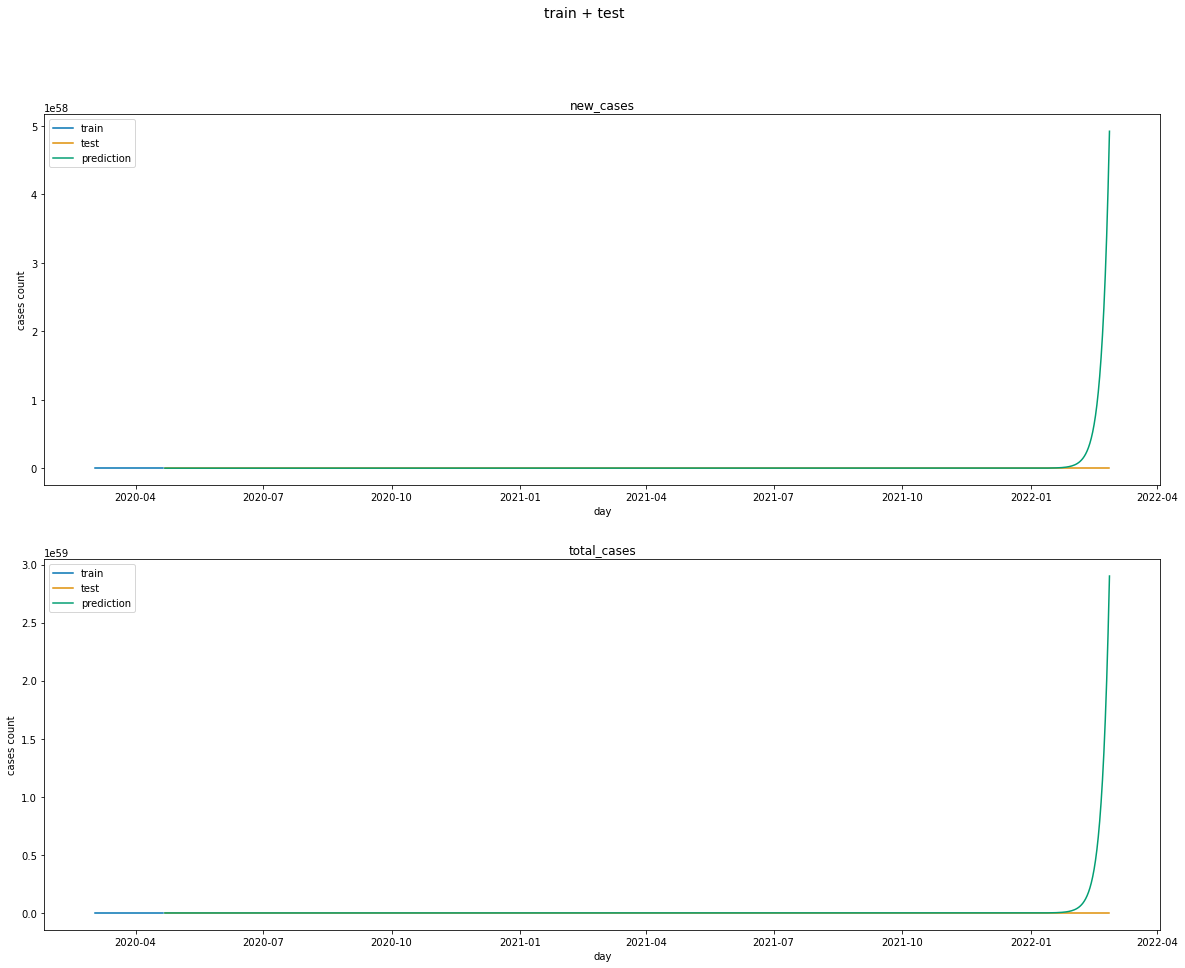

In [16]:
plot_lr_prediction()

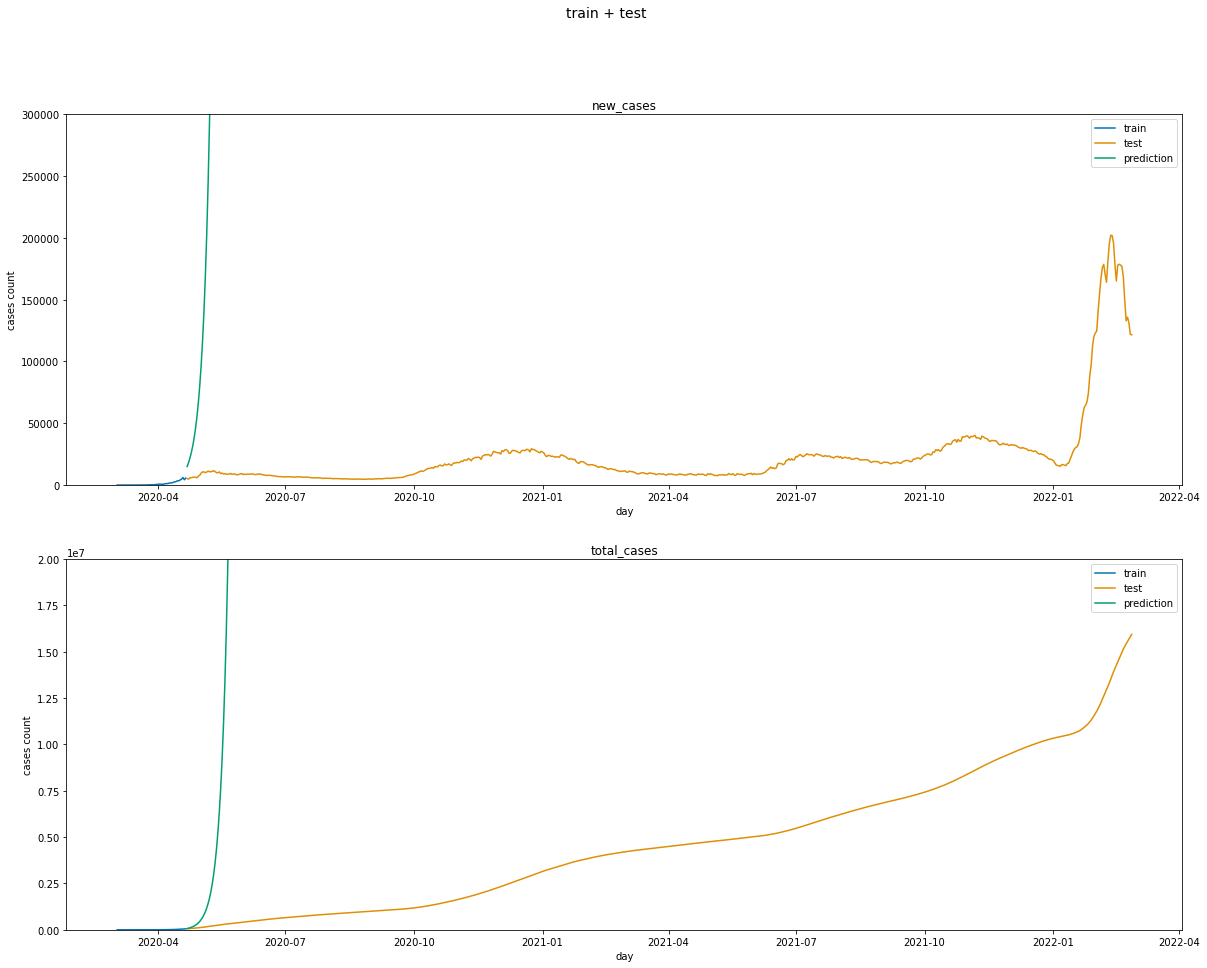

In [17]:
plot_lr_prediction(ylim1=3e5, ylim2=2e7)

2.b. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

In [18]:
class Regression:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
    
    @staticmethod
    def noise_var(X, y):
        lr = LinearRegression(fit_intercept=False)
        lr.fit(X, y)
        pred = lr.predict(X)
        return np.var(y - pred)
        
    def bayesian_update(self, X, y):
        noise = self.noise_var(X, y)
        inv_sigma = np.linalg.inv(self.sigma)
        self.sigma = np.linalg.inv(inv_sigma + np.matmul(X.T, X) / noise)
        self.mu = np.matmul(self.sigma, np.matmul(inv_sigma, self.mu.T) + np.matmul(X.T, y) / noise)        

In [19]:
mu0, sigma0 = np.array([0, 0]), 1 * np.array([[1, 0], [0, 1]])

exp_reg = Regression(mu0, sigma0)
exp_reg.bayesian_update(X_train, y_train)

mu:
 [0.13104732 0.18607077]
sigma:
 [[ 2.84603896e-02 -8.45351109e-04]
 [-8.45351109e-04  3.33866010e-05]]


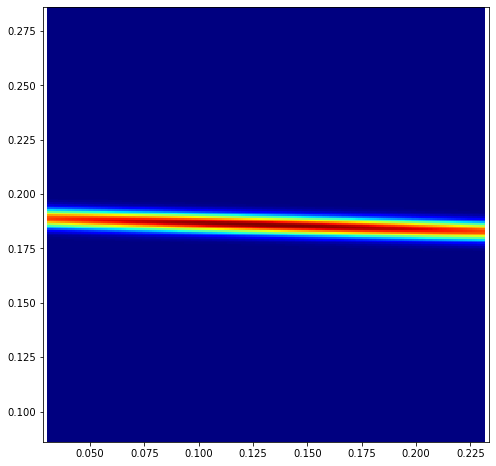

In [20]:
N = 250

mu, sigma = exp_reg.mu, exp_reg.sigma
print('mu:\n', mu)
print('sigma:\n', sigma)

x_min, x_max = mu[0] - 0.1, mu[0] + 0.1
y_min, y_max = mu[1] - 0.1, mu[1] + 0.1

X = np.linspace(x_min, x_max, N)
Y = np.linspace(y_min, y_max, N)
X, Y = np.meshgrid(X, Y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y    
    
Z = multivariate_normal.pdf(pos, mean=mu, cov=sigma)

fig = plt.figure(figsize=(8, 8))
plt.axis('equal')
plt.xlim((x_min, x_max))
plt.ylim((y_min, y_max))
plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet, shading='auto');

2.c. Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).

In [21]:
def sample_lines(mu, sigma, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    new_res = []
    total_res = []
    for w in my_w:
        y_pred = new_cases_predict(X_test, w)
        new_res.append(y_pred)
        
        y_cum_pred = total_cases_predict(y_pred, last_total_cases)
        total_res.append(y_cum_pred)
    return np.array(new_res), np.array(total_res)

In [22]:
def myplot_sample_lines(new_res, total_res, ylim1=None, ylim2=None):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 15))
    fig.suptitle('sample lines', fontsize=14)
    
    for i in range(len(new_res)):
        ax1.plot(test['date'], new_res[i], 'k-', lw=.4)
        
        ax2.plot(test['date'], total_res[i], 'k-', lw=.4)
        
    ax1.plot(test['date'], test['new_cases'], label='test')
    ax1.set_title('new_cases')
    ax1.set_xlabel('day')
    ax1.set_ylabel('cases count')
    ax1.legend()
    if ylim1 is not None:
        ax1.set_ylim((0, ylim1))
    
    ax2.plot(test['date'], test['total_cases'], label='test')
    ax2.set_title('total_cases')
    ax2.set_xlabel('day')
    ax2.set_ylabel('cases count')
    ax2.legend()
    if ylim2 is not None:
        ax2.set_ylim((0, ylim2))

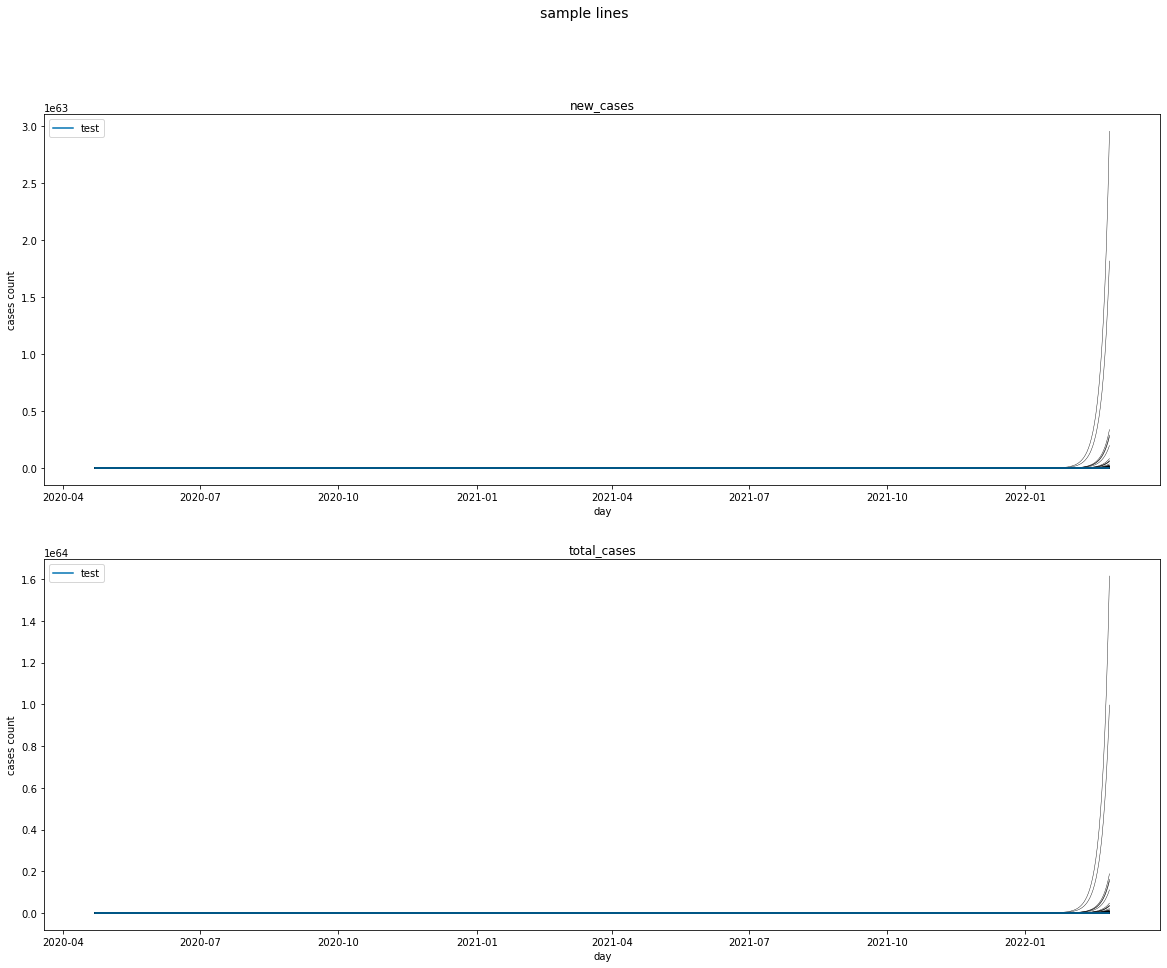

In [23]:
new_res, total_res = sample_lines(mu, sigma, n=200)
myplot_sample_lines(new_res, total_res)

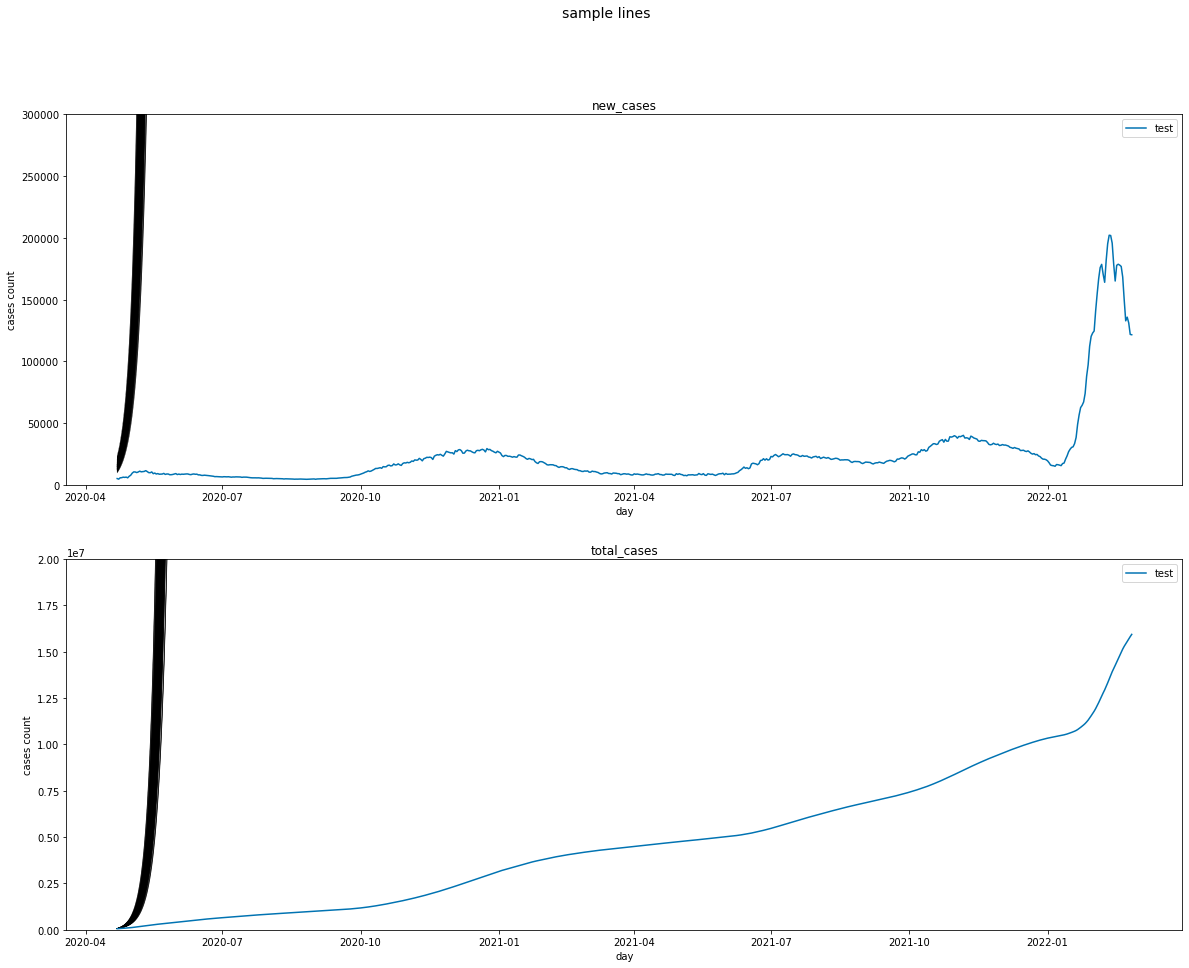

In [24]:
myplot_sample_lines(new_res, total_res, ylim1=3e5, ylim2=2e7)

In [25]:
y_pred = np.exp(test[['ones', 'day']].values.dot(mu))
y_cum_pred = np.cumsum(y_pred) + train["total_cases"].tail(1).values

In [26]:
def make_date_prediction():
    pred_days = ('2020-05-01', '2020-06-01', '2020-09-01')
    day_idxs = test[test['date'].isin(pred_days)].index
    
    print('Прогноз на:')
    for i, idx in enumerate(day_idxs):
        print(f'{pred_days[i]}: число случаев за день = {int(y_pred[idx])}, накопленное число случаев = {int(y_cum_pred[idx])}')

In [27]:
make_date_prediction()

Прогноз на:
2020-05-01: число случаев за день = 80442, накопленное число случаев = 452849
2020-06-01: число случаев за день = 25738220, накопленное число случаев = 151571931
2020-09-01: число случаев за день = 699928064449066, накопленное число случаев = 4122433611229369


In [28]:
def plot_predictions(ylim1=None, ylim2=None):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 15))
    fig.suptitle('predictions', fontsize=14)
    
    ax1.plot(test['date'], test['new_cases'], label="test")
    ax1.plot(test['date'], y_pred, color="red", label="MAP гипотеза")
    ax1.fill_between(test['date'], np.mean(new_res, axis=0) - np.std(new_res, axis=0), np.mean(new_res, axis=0) + np.std(new_res, axis=0), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax1.legend()
    if ylim1 is not None:
        ax1.set_ylim((0, ylim1))
    
    ax2.plot(test['date'], test['total_cases'], label="test")
    ax2.plot(test['date'], y_cum_pred, color="red", label="MAP гипотеза")
    ax2.fill_between(test['date'], np.mean(total_res, axis=0) - np.std(total_res, axis=0), np.mean(total_res, axis=0) + np.std(total_res, axis=0), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax2.legend()
    if ylim2 is not None:
        ax2.set_ylim((0, ylim2))

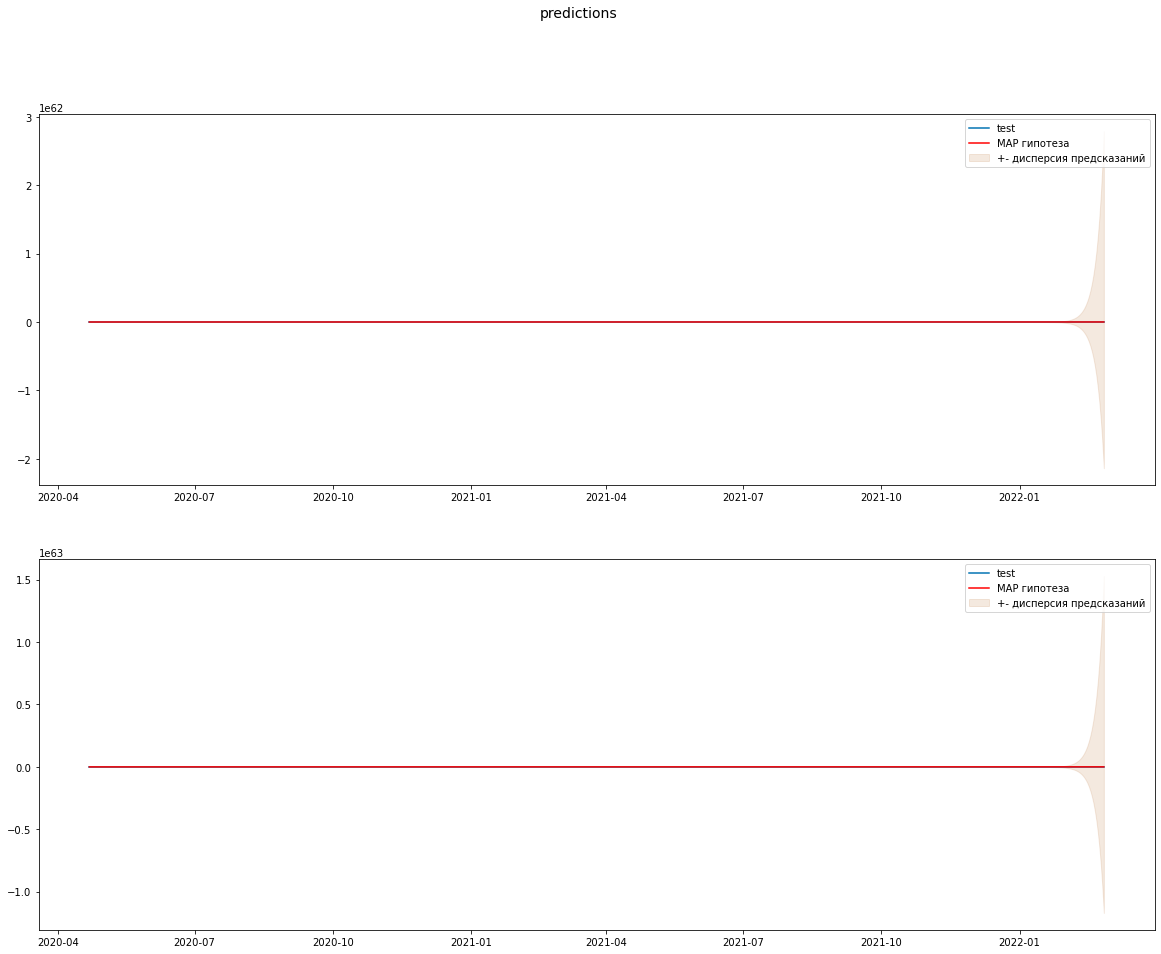

In [29]:
plot_predictions()

3. Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана. Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от t.

3.a. Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.

Можно взять производную от функции сигмоиды и аппроксимировать ее переменной new_cases. Данная переменная представляет собой величину за единицу времени (1 день) и может быть рассмотрена как прирост переменной total_cases.

$$ Ф(x) = \frac{c}{\sqrt{2\pi}} \int_{-\infty}^{x} exp^{-\frac{1}{2}{(\frac{t - a}{b})^2}} \,dt $$
$$ y = \frac{c}{b\sqrt{2\pi }}exp^{-\frac{1}{2}{(\frac{x - a}{b})^2}} $$
$$ ln(y) = const - \frac{1}{2}{(\frac{x - a}{b})^2} = const - \frac{x^2 -ax^2 + a^2}{2b^2} = A + Bx + Cx^2 $$

3.b. Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.

In [30]:
X_train = train[['ones', 'day', 'day_2']].values
y_train = train['log_new_cases'].values

X_test = test[['ones', 'day', 'day_2']].values

In [31]:
lr = LinearRegression(fit_intercept=False)
lr.fit(X_train, y_train)

print(f'ln(y) = {lr.coef_[0]} + ({lr.coef_[1]} * day) + ({lr.coef_[2]} * day^2)')

ln(y) = -0.6740430253611442 + (0.27928241313613955 * day) + (-0.0018297906166869513 * day^2)


In [32]:
y_pred = new_cases_predict(X_test, lr.coef_)
y_cum_pred = total_cases_predict(y_pred, last_total_cases)

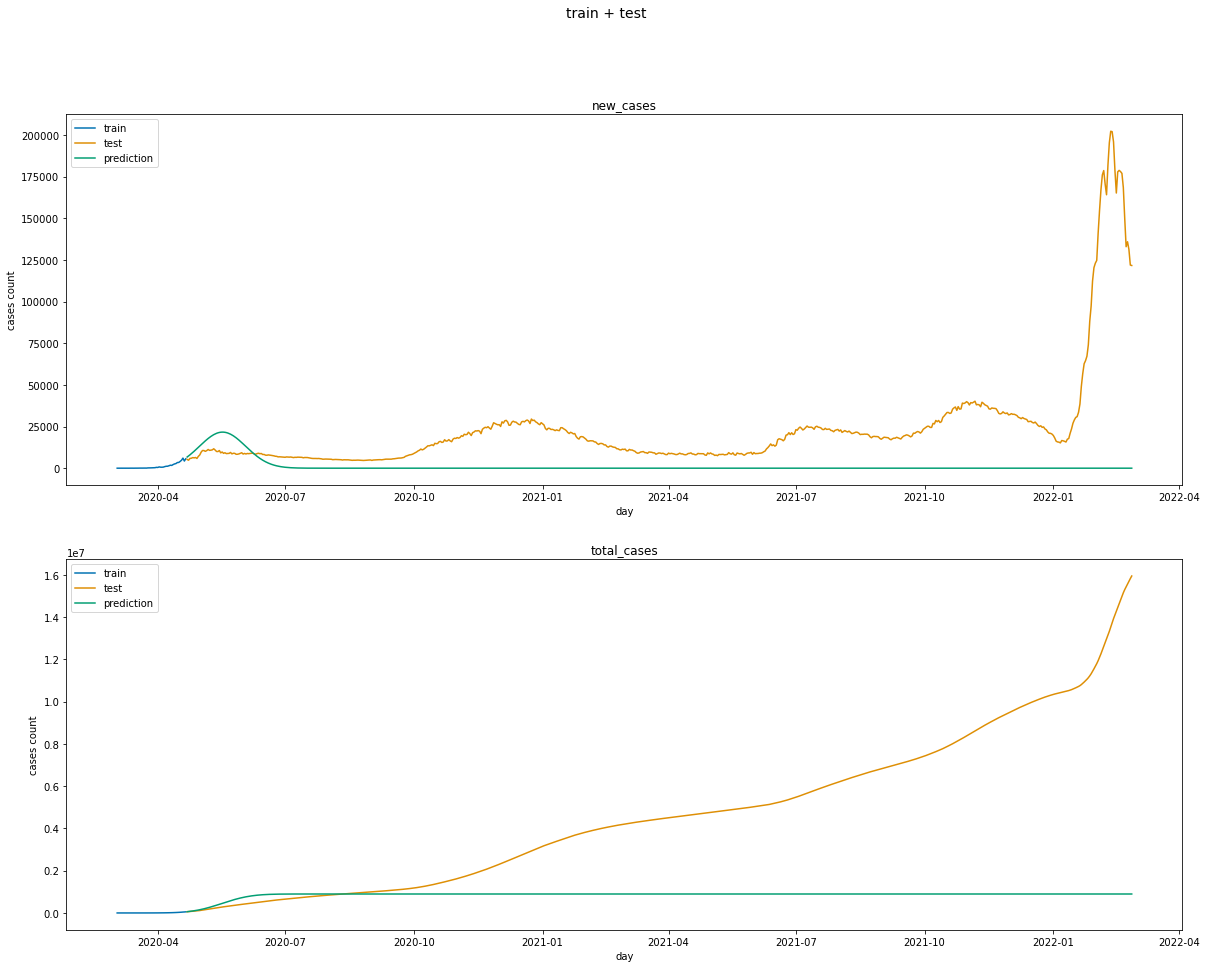

In [33]:
plot_lr_prediction()

In [34]:
mu0, sigma0 = np.array([0, 0, 0]), 1 * np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

exp_reg = Regression(mu0, sigma0)
exp_reg.bayesian_update(X_train, y_train)

In [35]:
mu, sigma = exp_reg.mu, exp_reg.sigma
print('mu:\n', mu)
print('sigma:\n', sigma)

mu:
 [-0.6429853   0.27679809 -0.00178859]
sigma:
 [[ 4.46128406e-02 -3.53279772e-03  5.82943886e-05]
 [-3.53279772e-03  3.68983203e-04 -6.82512164e-06]
 [ 5.82943886e-05 -6.82512164e-06  1.34498814e-07]]


3.c. Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

In [36]:
new_res, total_res = sample_lines(mu, sigma, n=200)

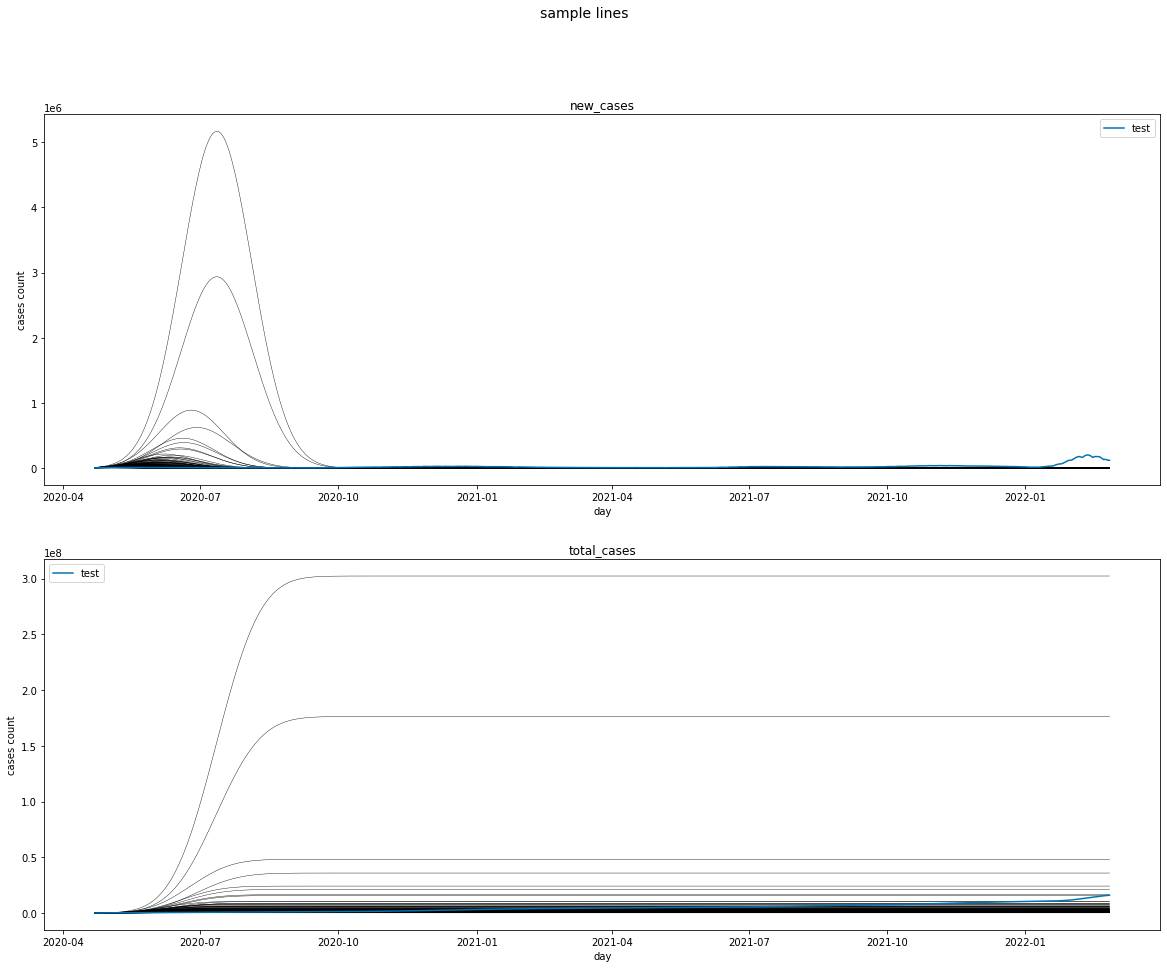

In [37]:
myplot_sample_lines(new_res, total_res)

In [38]:
make_date_prediction()

Прогноз на:
2020-05-01: число случаев за день = 13301, накопленное число случаев = 151583
2020-06-01: число случаев за день = 14591, накопленное число случаев = 736077
2020-09-01: число случаев за день = 0, накопленное число случаев = 896757


In [39]:
print(f'Всего накопленное число случаев = {int(y_cum_pred[-1])}')

Всего накопленное число случаев = 896757


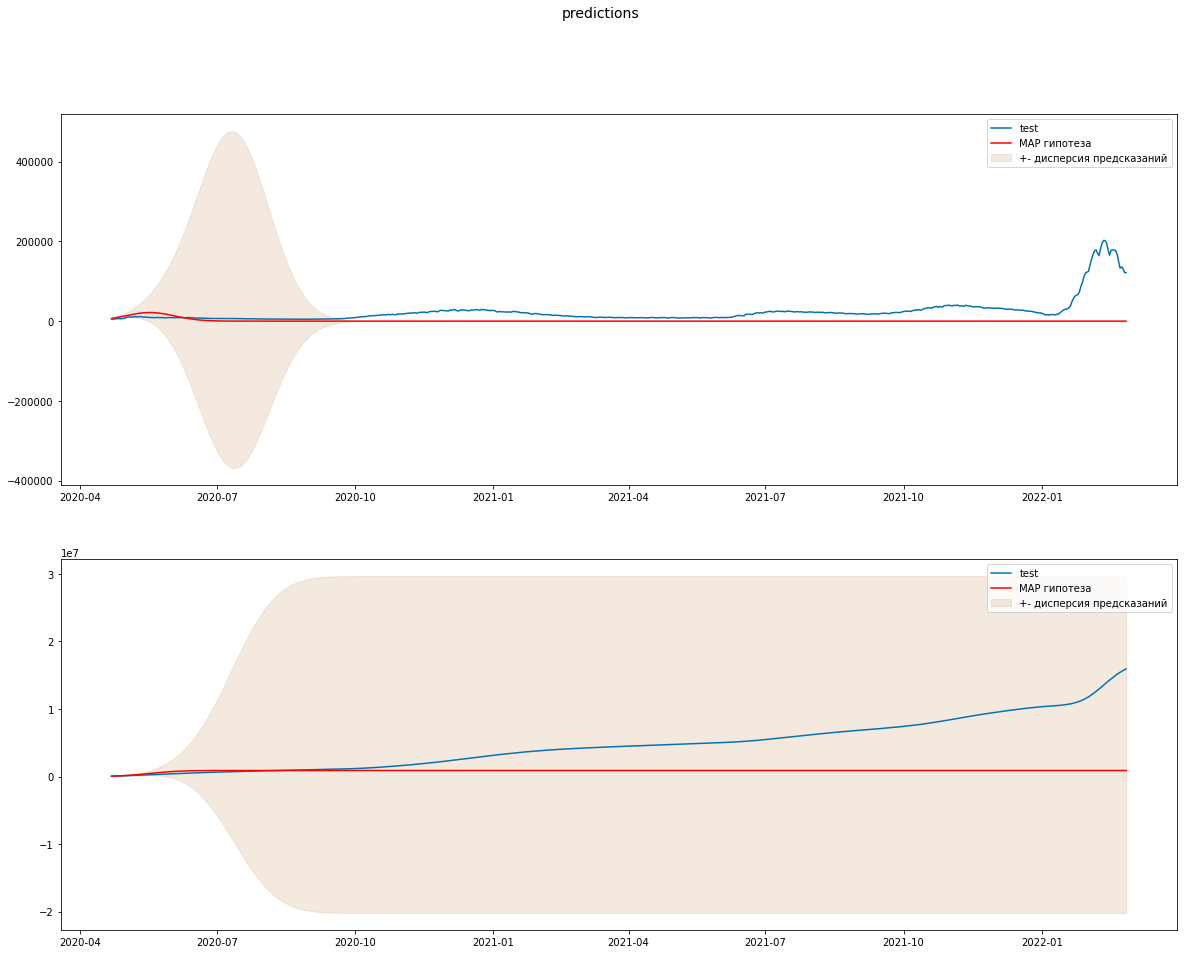

In [40]:
plot_predictions()

In [41]:
print(f'Общее число случаев в оптимистичном сценарии: {int(np.percentile(total_res[:, -1], 10))}')
print(f'Общее число случаев в пессимистичном сценарии: {int(np.percentile(total_res[:, -1], 90))}')

Общее число случаев в оптимистичном сценарии: 349324
Общее число случаев в пессимистичном сценарии: 5470455


5. Что вы поняли из этого упражнения? Что можно сказать про коронавирус по итогам такого моделирования? Как принять решение, например, о том, нужно ли вводить карантин?

На примере данного упражнения показано, что прогнозирование на долгосрочный период реальных событий очень затруднительно. Даже если динамика на обучающем периоде выглядит как определенная закономерность (например, экспоненциальная) дальнейший тренд целевой переменной может сильно отличаться от прогнозируемых величин, кроме того, перед выбором формы модели необходимо понимать природу данных и наличие ограничений (например, экспоненциальный рост невозможен бесконечно из-за конечно числа населения).

В случае с сигмоидальной закономерностью модель не учитывает возможность наступления других волн коронавируса. В таком случае возможно будет улучшением введение нескольких гауссовских компонент. Если брать в расчет такую модель, то решение о необходимость введения карантина можно принимать в зависимости от области расположения на гауссиане: при периоде возрастания гауссиана возможно стоит вводить карантин, при периоде понижения гауссиана - снимать ограничения.